This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/feature-selection.ipynb). It investigates which attributes in the database to select for further study. First we must import the necessary installed modules.

In [1]:
import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

Next we need to import a local module to calculate some advanced stats not stored in the database.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from nba.database import Database

The code below simply customizes font sizes for all the plots that follow.

In [3]:
plt.rc('font', size=14)        # controls default text sizes
plt.rc('axes', titlesize=16)   # fontsize of the axes title
plt.rc('axes', labelsize=16)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)  # legend fontsize

# Preprocess the Data

The next step is to bring in the data similar to what was done during [data exploration](data-exploration.md).

In [4]:
database = Database('../nba.db')
season_stats = database.season_stats()

We then need to connect to the database generated during the [data wrangling](data-wrangling.md) process to combine the calculated stats with the games table.

In [5]:
conn = sqlite3.connect('../nba.db')
games = pd.read_sql('SELECT * FROM games', conn)

The next step is to remove any games where the database does not have a value for whether or not the home team won. Specifically, this is to account for a game between the Boston Celtics and Indiana Pacers during the [2012-13 season](http://www.basketball-reference.com/leagues/NBA_2013.html) that was canceled as a result of the [Boston Marathon bombings](https://www.si.com/nba/point-forward/2013/04/16/boston-marathon-bombing-terror-attack-celtics-pacers-game-cancelled-nba).

In [6]:
games[[x is None for x in games.HOME_WL]]

,SEASON,ID,HOME_TEAM_ID,AWAY_TEAM_ID,GAME_DATE,MATCHUP,HOME_WL
27708,2012,0021201214,1610612738,1610612754,2013-04-16,BOS vs. IND,None


In [7]:
games = games[[x is not None for x in games.HOME_WL]]

The next step is to merge the calculated stats with the games table. The code below joins the games table with the stats table initially by home team stats and followed by away team stats.

In [8]:
seasons = season_stats.filter(regex='SEASON|TEAM')
games = games.merge(seasons, left_on=['SEASON', 'HOME_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'])
games = games.merge(seasons, left_on=['SEASON', 'AWAY_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'],
                    suffixes=('', '_AWAY'))
games = games[games.SEASON >= 1990]

We then identify which stats in the database we want to select from. This is mainly to remove features like game and team IDs that have no influence on a game's outcome.

In [9]:
stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'AST', 'OREB', 'DREB', 'REB', 'STL', 'TOV', 'BLK',
         'EFG', 'TOV_PCT', 'OREB_PCT', 'DREB_PCT', 'FT_PER_FGA', 'FOUR_FACTORS',
         'SRS', 'PLUS_MINUS', 'OFF_RTG', 'DEF_RTG', 'NET_RTG']
labels = ['TEAM_' + s for s in stats]
labels.extend(['TEAM_' + s + '_AWAY' for s in stats])

The input data is selected from the labels above and the output data is the W/L values encoded to be either 0 or 1 using scikit-learn's [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) class.

In [10]:
# Select lables from the games DataFrame and turn the HOME_WL column to a numeric column
X, y = games[labels], LabelEncoder().fit_transform(games.HOME_WL)

The dataset is then split into training and test data by utilizing the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function with 25% of the data reserved for testing. The split is stratified using the class attribute to ensure a similar distribution of the two classes between the training and test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

We should verify that the data was indeed stratified by ensuring the percentage of games won by the home team is similar in both the training and test sets. The mean of the labels in `y_train` and `y_test` show the home team win percentage is about 60%, the same amount that was calculated during [data exploration](data-exploration.md).

In [12]:
print "Training set home win percentage: {:.2f}%".format(np.mean(y_train) * 100)
print "Test set home win percentage: {:.2f}%".format(np.mean(y_test) * 100)

Training set home win percentage: 60.33%
Test set home win percentage: 60.32%


I then save the datasets to ensure the same train/test split is applied in other notebooks.

In [13]:
f = open('databall.pkl', 'wb')
pickle.dump([X, X_train, X_test, y, y_train, y_test], f)
f.close()

# Select Features Automatically

The code below uses [`SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to select the 10 best attributes according to the [ANOVA F-value](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif). The majority of the selected attributes deal with points (SRS, offensive rating, etc). The only attribute selected not directly related to points is the weighted sum of the four factors. The four factors are weighted according to Oliver's selected weights (discussed during [data wrangling](data-wrangling.md)) and combined into a single metric as:

$$FF=0.4*EFG\% + 0.2*OREB\% + 0.15*FTR - 0.25*TOV\%$$

In [14]:
model = SelectKBest(f_classif, k=10).fit(X_train, y_train)

for label in X_train.columns[model.get_support()]:
    print label

TEAM_FOUR_FACTORS
TEAM_SRS
TEAM_PLUS_MINUS
TEAM_OFF_RTG
TEAM_DEF_RTG
TEAM_NET_RTG
TEAM_SRS_AWAY
TEAM_PLUS_MINUS_AWAY
TEAM_OFF_RTG_AWAY
TEAM_NET_RTG_AWAY


Selecting the 10 best features using a [chi-square test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) selects the same 10 attributes as the ANOVA F-value above. The chi-square test only works on positive values, so each feature in the training data is scaled to fall between 0 and 1 using the [`MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.

In [15]:
model = SelectKBest(chi2, k=10).fit(MinMaxScaler((0, 1)).fit_transform(X_train), y_train)

for label in X_train.columns[model.get_support()]:
    print label

TEAM_FOUR_FACTORS
TEAM_SRS
TEAM_PLUS_MINUS
TEAM_OFF_RTG
TEAM_DEF_RTG
TEAM_NET_RTG
TEAM_SRS_AWAY
TEAM_PLUS_MINUS_AWAY
TEAM_DEF_RTG_AWAY
TEAM_NET_RTG_AWAY


# Define Support Functions

The function below plots a cross-validated ROC curve. It also provides the option to plot ROC curves for each fold of the cross validation. It first performs a k-fold cross-validation to get the predicted probabilities of each instance using [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) and [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold). The predicted probabilities of the positive class (home team wins) are input into [`roc_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) and [`roc_auc_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) to get the mean ROC curve and area under the curve. The function then loops over each fold using calculates ROC curves and areas for each fold if the user specifies that individual folds are to be plotted as well.

In [16]:
def cross_val_roc_curve(model, X, y, ax, k=10, label='Mean', show_folds=False):
    # Compute cross-validated ROC curve and area under the curve
    kfold = StratifiedKFold(n_splits=k)
    proba = cross_val_predict(model, X, y, cv=kfold, method='predict_proba')
    mean_fpr, mean_tpr, thresholds = roc_curve(y, proba[:, 1])
    mean_auc = roc_auc_score(y, proba[:, 1])
    
    # Loop over k folds and get ROC curve for each fold
    if show_folds:
        for i, (train, test) in enumerate(kfold.split(X, y)):
            # Fit model for the ith fold
            proba = model.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
            
            # Compute ROC curve and area under the curve
            fpr, tpr, thresholds = roc_curve(y[test], proba[:, 1])
            roc_auc = roc_auc_score(y[test], proba[:, 1])
            ax.plot(fpr, tpr, lw=1, label='Fold %d (Area = %0.2f)' % (i+1, roc_auc))
    
        ax.plot(mean_fpr, mean_tpr, 'k--', label='%s (Area = %0.2f)' % (label, mean_auc), lw=2)
    else:
        ax.plot(mean_fpr, mean_tpr, label='%s (Area = %0.2f)' % (label, mean_auc), lw=2)

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

The function below is similar to the ROC function above, but plots a cross-validated precision/recall curve using [`precision_recall_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve) and [`average_precision_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).

In [17]:
def cross_val_precision_recall_curve(model, X, y, ax, k=10, label='Mean', show_folds=False):
    # Compute cross-validated precision/recall curve and area under the curve
    kfold = StratifiedKFold(n_splits=k)
    proba = cross_val_predict(model, X, y, cv=kfold, method='predict_proba')
    mean_precision, mean_recall, thresholds = precision_recall_curve(y, proba[:, 1])
    mean_auc = average_precision_score(y, proba[:, 1])
    
    # Loop over k folds and get precision/recall curve for each fold
    if show_folds:
        for i, (train, test) in enumerate(kfold.split(X, y)):
            # Fit model for the ith fold
            proba = model.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
            
            # Compute precision/recall curve and area under the curve
            precision, recall, thresholds = precision_recall_curve(y[test], proba[:, 1])
            pr_auc = average_precision_score(y[test], proba[:, 1])
            ax.plot(recall, precision, lw=1, label='Fold %d (Area = %0.2f)' % (i+1, pr_auc))
    
        ax.plot(mean_recall, mean_precision, 'k--', label='%s (Area = %0.2f)' % (label, mean_auc), lw=2)
    else:
        ax.plot(mean_recall, mean_precision, label='%s (Area = %0.2f)' % (label, mean_auc), lw=2)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

This function is simply a convenience function to plot ROC and precision/recall curves side by side.

In [18]:
def cross_val_curves(model, X, y, k=10):
    plt.figure(figsize=(16, 6))
    
    # Plot ROC curve
    ax = plt.subplot(121)
    cross_val_roc_curve(model, X, y, ax, k=k, label='Mean', show_folds=True)
    ax.legend()
    
    # Plot precision/recall curve
    ax = plt.subplot(122)
    cross_val_precision_recall_curve(model, X, y, ax, k=k, label='Mean', show_folds=True)
    ax.legend()
    ax.set_ylim(0.4)
    
    plt.show()

The function below selects columns from a DataFrame that match a given substring. This is useful for selecting home and away stats of the same type. This can be used with a scikit-learn [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#) as a preprocessing step to easily select multiple columns without specifying home and away stats separately.

In [19]:
def select_columns(df, names, columns=X_train.columns):
    return df[:, [i for i, col in enumerate(columns) if any(n in col for n in names)]]

# Compare Attribute Groupings

I trained logistic regression models (using scikit-learn's [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class) to compare the predictive capability of different groups of features since logistic regression is well-suited to this type of binary classification problem. The plots below show 10-fold cross-validated ROC and precision/recall curves using home and away SRS as the selected attributes. There is little spread among the different folds. The areas under the curves for the individual folds do not deviate more than 0.02 from the cross validated curves, which are much smoother than the individual fold curves.

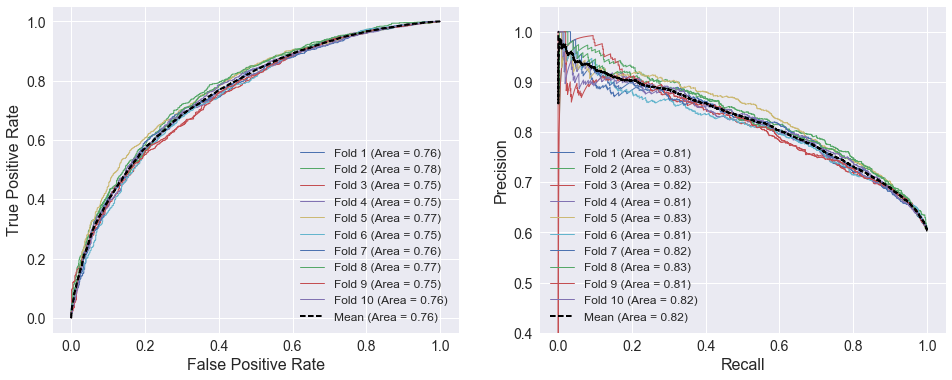

In [20]:
attributes = ['TEAM_SRS', 'TEAM_SRS_AWAY']
model = LogisticRegression()
cross_val_curves(model, X_train[attributes], y_train)

The ROC and precision/recall curves below use the four factors defined during [data wrangling](data-wrangling.md). A [`FunctionTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) that selects columns from the `DataFrame` is added to simplify the process of specifying all the attributes. The selector and classifier are combined into a `Pipeline` using the [`make_pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) function. The spread among the individual folds are similar to those using SRS above. However, the areas under the cross-validated curves are lower, indicating SRS is a more predictive variable of home team performance than the four factors.

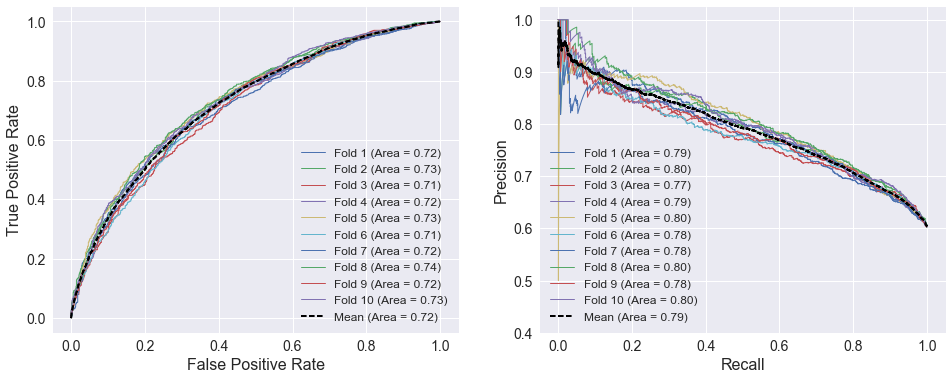

In [21]:
# Define four factors
four_factors = ['EFG', 'TOV_PCT', 'OREB_PCT', 'DREB_PCT', 'FT_PER_FGA']
    
# Make a pipeline that selects the desired attributes prior to calling classifier
selector = FunctionTransformer(partial(select_columns, names=four_factors))
model = make_pipeline(selector, LogisticRegression())
cross_val_curves(model, X_train, y_train)

The plots below show 10-fold cross-validated ROC and precision/recall curves using the weighted four factors as the selected attributes. The curves show that the weighted four factors have less predictive capability than both SRS and the four factors, given that the areas under both curves below are lower than the previous curves.

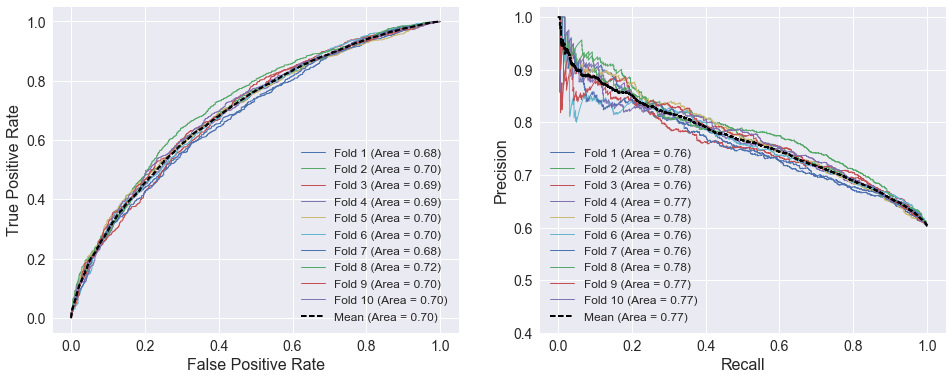

In [22]:
attributes = ['TEAM_FOUR_FACTORS', 'TEAM_FOUR_FACTORS_AWAY']
model = LogisticRegression()
cross_val_curves(model, X_train[attributes], y_train)

The ROC and precision/recall curves below use the 10 best attributes selected above. The curves are very similar to the SRS curves above. Home and away SRS are included among the selected attributes, but adding 8 extra features does not improve the model's performance as indicated by the areas under the curves.

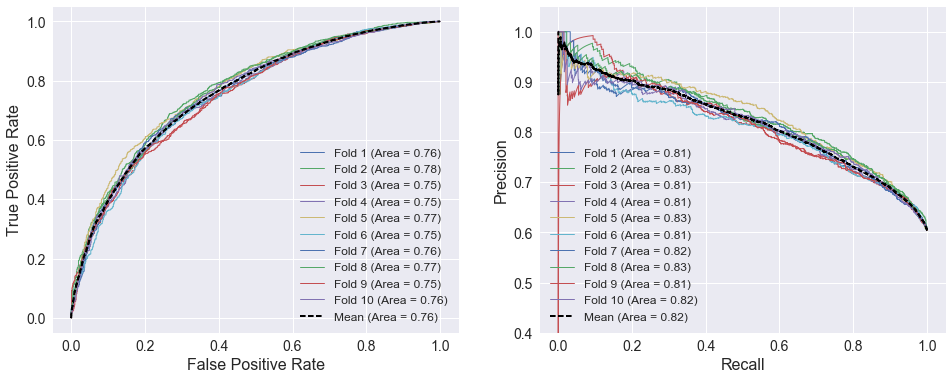

In [23]:
# Make pipeline that selects attributes prior to calling the classifier
selector = SelectKBest(f_classif, k=10)
model = make_pipeline(selector, LogisticRegression())
cross_val_curves(model, X_train, y_train)

The ROC and precision/recall curves below compare logistic regression models using different attributes. The curves using SRS, net rating, offensive/defensive ratings, and plus/minus are nearly identical. This is not terribly surprising since SRS is average margin of victory (equal to plus/minus and similar to net rating) adjusted for strength of schedule, and net rating is derived from the offensive and defensive ratings. All four outperform the two models based on the four factors.

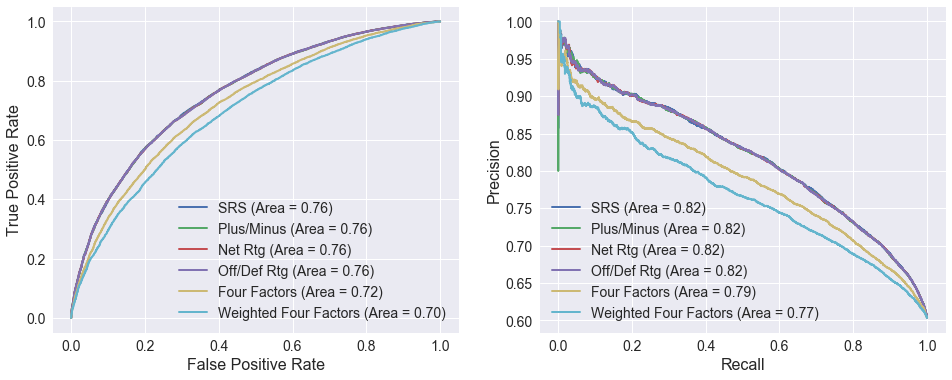

In [24]:
# Define attributes to use for each curve
attributes = [['SRS'], ['PLUS_MINUS'], ['NET_RTG'], ['OFF_RTG', 'DEF_RTG'],
              four_factors, ['FOUR_FACTORS']]
labels = ['SRS', 'Plus/Minus', 'Net Rtg', 'Off/Def Rtg', 'Four Factors', 'Weighted Four Factors']

plt.figure(figsize=(16, 6))
ax = plt.subplot(121)

# Plot ROC curves for each set of attributes
for (a, l) in zip(attributes, labels):
    # Make transformer that selects the desired attributes from the DataFrame
    selector = FunctionTransformer(partial(select_columns, names=a))
    
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, LogisticRegression())
    cross_val_roc_curve(model, X_train, y_train, ax, label=l)

ax.legend(fontsize=14)
ax = plt.subplot(122)

# Plot ROC curves for each set of attributes
for (a, l) in zip(attributes, labels):
    # Make transformer that selects the desired attributes from the DataFrame
    selector = FunctionTransformer(partial(select_columns, names=a))
    
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, LogisticRegression())
    cross_val_precision_recall_curve(model, X_train, y_train, ax, label=l)
    
ax.legend(fontsize=14)
plt.show()